# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [18]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [19]:
env = UnityEnvironment(file_name="/home/starkj/Udacity/ReinforcementLearning/drlnd_repo/p1_navigation/Banana_Linux/Banana.x86")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [20]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

print(brain)

Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [21]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [22]:
### Ignore this cell

''' Now that I have proved the environment setup, this cell will get in the way, so commenting it out.
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))
'''

' Now that I have proved the environment setup, this cell will get in the way, so commenting it out.\nenv_info = env.reset(train_mode=False)[brain_name] # reset the environment\nstate = env_info.vector_observations[0]            # get the current state\nscore = 0                                          # initialize the score\nwhile True:\n    action = np.random.randint(action_size)        # select an action\n    env_info = env.step(action)[brain_name]        # send the action to the environment\n    next_state = env_info.vector_observations[0]   # get the next state\n    reward = env_info.rewards[0]                   # get the reward\n    done = env_info.local_done[0]                  # see if episode has finished\n    score += reward                                # update the score\n    state = next_state                             # roll over the state to next time step\n    if done:                                       # exit loop if episode finished\n        break\n    \nprint(

In [23]:
'''
env.close()
'''

'\nenv.close()\n'

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [24]:
##### Set up the environment

import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline


In [25]:
##### The NN model

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        fc1_size = 10*state_size
        fc2_size =  8*state_size
        
        self.fc1 = nn.Linear(state_size, fc1_size)
        self.fc2 = nn.Linear(fc1_size, fc2_size)
        self.fc3 = nn.Linear(fc2_size, action_size)
        self.dropout = nn.Dropout(0.1)
        

    def forward(self, state):
        """Build a network that maps state -> action values."""
        
        #x = self.dropout(state)
        x = state
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        
        #x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        
        #x = self.dropout(x)
        x = self.fc3(x) #no activation function
        
        return x


In [26]:
##### Replay buffer

# NB: this is based on instructor-provided code from the DQN lundar lander exercise.

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [27]:
##### The agent

# NB: this section of code is based on instructor-provided code from the DQN lunar lander exercise.

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DqnAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed=321):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of state vector
            action_size (int): dimension of action vector
            seed (int): seed for the PRNG
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Set up two NNs for the dual DQN; local is the solution, target holds the w- weights
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.0):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ### John's code
        
        # the act() method is responsible for ensuring the local model is in train mode so we don't 
        # need to do that here
        
        # get the actions predicted by the target model (result is tensor of [batch_size, 1])
        # detach it from the computational graph so that gradients won't be backpropagated through 
        # it (we only want to do that on the local network)
        target_actions = self.qnetwork_target(next_states).detach()
        
        # Find the max Q value for each state; (column 0 of the named tuple from max(), then convert 
        # to a column tensor [batch_size, 1]
        max_q = target_actions.max(1)[0].unsqueeze(1)
        
        # compute the target Q values (force zero value for any terminal states)
        y_target = rewards + gamma*max_q*(1 - dones)
        
        # find the expected Q values from the current model
        y_model = self.qnetwork_local(states)
        
        # select the max Q value for each state (the gather method is explained well in 
        # https://stackoverflow.com/questions/50999977/what-does-the-gather-function-do-in-pytorch-in-layman-terms)
        y_model = y_model.gather(1, actions)
        
        # compute the loss & weight gradient and apply to the model
        self.optimizer.zero_grad()
        loss = F.mse_loss(y_model, y_target)
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [28]:
##### Training function

# agent - the agent to be trained
# max_episodes - the max number of episodes you want to attempt before training ceases
# max_time_steps - the max number of time steps allowed before an episode is forced to end
# eps_init - initial value of epsilon at the beginning of training
# eps_min - the minimum value epsilon is allowed to get as a result of decay
# eps_decay - the factor by which epsilon is decayed after each episode
# returns a list of final scores for each episode

WINNING_SCORE = 13.0 # accepted value of 100-episode average score that will win the banana game


def train(agent, max_episodes=2000, max_time_steps=1000, eps_init=1.0, eps_min=0.01, eps_decay=0.995):

    # set up the score monitor so we can check training progress
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores

    # initialize for epsilon-greedy actions
    epsilon = eps_init
    
    # loop over episodes
    for e in range(max_episodes+1):
        
        # reset to begin a new episode
        env_info = env.reset(train_mode=True)[brain_name]
        num_agents = len(env_info.agents)
        if num_agents > 1:
            print('\n///// CAUTION: Number of agents =', num_agents)
        action_size = brain.vector_action_space_size
        state = env_info.vector_observations[0]
        state_size = len(state)
        score = 0 #total score for this episode
        sum_time_steps = 0
        num_max_time_steps = 0
        
        # loop over time steps
        for t in range(max_time_steps):
            
            # get the agent's next action
            action = agent.act(state, epsilon)
            
            # get the resulting state & reward from environment
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            # update the agent
            agent.step(state, action, reward, next_state, done)
            
            # update counters & states for the next time step
            score += reward
            state = next_state
            if done:
                sum_time_steps += t
                break
            
        # collect stats on length of episodes
        if not done:
            sum_time_steps += max_time_steps
            num_max_time_steps += 1
            
        # update score bookkeeping and decide if training is complete
        scores.append(score)
        scores_window.append(score)
        epsilon = max(epsilon*eps_decay, eps_min)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)), end="")
        if e > 0  and  e % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, epsilon = {:.2f}'.format(
                    e, np.mean(scores_window), epsilon))
        if np.mean(scores_window) >= WINNING_SCORE:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(e, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pt')
            break

    print("Avg episode length = {} time steps.".format(sum_time_steps/e))
    print("Number of max length episodes: {}".format(num_max_time_steps))
    return scores

Episode 100	Average Score: 1.21, epsilon = 0.60
Episode 200	Average Score: 3.96, epsilon = 0.37
Episode 300	Average Score: 7.22, epsilon = 0.22
Episode 400	Average Score: 10.08, epsilon = 0.13
Episode 500	Average Score: 11.78, epsilon = 0.08
Episode 598	Average Score: 13.06
Environment solved in 598 episodes!	Average Score: 13.06
Avg episode length = 0.5 time steps.
Number of max length episodes: 0


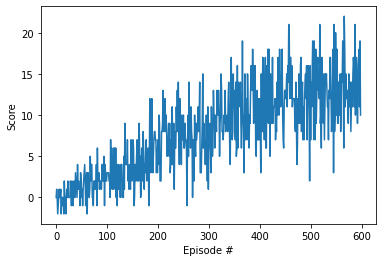

In [29]:
##### Train the model & observe its progress

a = DqnAgent(37, 4)

scores = train(a)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

env.close()

In [30]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.